# Filter viral barcodes in transcripts
This notebook filters viral barcodes in 10X transcriptome data to remove UMIs that are likely derived from leaked transcripts.

## Notebook setup
Import python modules:

In [1]:
from IPython.display import display

import pandas as pd

import plotnine as p9

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [2]:
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial2_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_by_cell_corrected_csv = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_corrected.csv.gz'
expt = 'scProgenyProduction_trial2'
viral_bc_by_cell_filtered_csv = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_filtered.csv.gz'
plot = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_filtered.pdf'
barcoded_viral_genes = ['fluHA', 'fluNA']
fdr = 0.0001

## Organize data

Read the viral barcode UMI counts data into a pandas dataframe:

In [3]:
viral_bc_counts = pd.read_csv(viral_bc_by_cell_corrected_csv)
viral_bc_counts = (viral_bc_counts
                   .rename(columns={'count': 'viral_bc_UMIs'}))
assert set(viral_bc_counts['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(viral_bc_counts)

,cell_barcode,gene,viral_barcode,viral_bc_UMIs
0,AAACCCAAGTAGGTTA,fluHA,ACGTTATTGATTGAGA,1
1,AAACCCAAGTAGGTTA,fluHA,AGAATCGACACATGTC,14
2,AAACCCAAGTAGGTTA,fluHA,AGCCATAGTCTAAAGG,8
3,AAACCCAAGTAGGTTA,fluHA,AGGATGATTTTTTTGT,5
4,AAACCCAAGTAGGTTA,fluHA,CACGGATGGTGTACGA,12
...,...,...,...,...
55238,TTTGTTGCATGTGGTT,fluNA,TTCCTCAGCCTTTAAG,3
55239,TTTGTTGTCTAGGAAA,fluNA,GAACCCGATGGGGAAT,26
55240,TTTGTTGTCTAGGAAA,fluNA,TAAGGTAAAATAATAG,1
55241,TTTGTTGTCTAGGAAA,fluNA,TAAGGTATAATTCTAG,4


Read the total number of UMIs per cell into a pandas dataframe. Only keep relevant columns.

In [4]:
all_cells = pd.read_csv(viral_tag_by_cell_csv)
all_cells = all_cells[['cell_barcode',
                       'infected',
                       'infecting_viral_tag',
                       'total_UMIs',
                       'viral_UMIs',
                       'cellular_UMIs',
                       'frac_viral_UMIs']]
display(all_cells)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs
0,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901
1,AAACCCACAAGGCCTC,True,syn,10304,1485,8819,0.144119
2,AAACCCACACACACGC,True,both,7395,3320,4075,0.448952
3,AAACCCATCGTGCATA,True,syn,2764,1597,1167,0.577786
4,AAACCCATCTACTGCC,False,none,6313,3,6310,0.000475
...,...,...,...,...,...,...,...
7436,TTTGGTTGTTAAGCAA,False,none,8528,29,8499,0.003401
7437,TTTGGTTTCGTCGCTT,False,none,6492,6,6486,0.000924
7438,TTTGTTGCATGTGGTT,True,wt,3016,1680,1336,0.557029
7439,TTTGTTGTCGTCGGGT,False,none,11070,2,11068,0.000181


Sanity check that `total_UMIs` is equal to `viral_UMIs + cellular_UMIs`:

In [5]:
assert bool((all_cells['total_UMIs'] ==
             all_cells['viral_UMIs'] +
             all_cells['cellular_UMIs'])
            .all()), "UMI counts do not add up"

Merge dataframes:

In [6]:
viral_bc_frac = pd.merge(
    left=pd.concat([all_cells.assign(gene=gene)
                    for gene in barcoded_viral_genes]),
    right=viral_bc_counts,
    how='outer',
    on=['cell_barcode', 'gene'],
    validate='one_to_many')
assert (viral_bc_frac['cell_barcode'].unique() ==
        all_cells['cell_barcode'].unique()).all(), \
       "Cell barcodes in merged dataframe don't " \
       "match barcodes in source data."
assert (viral_bc_frac['viral_barcode'].nunique() ==
        viral_bc_counts['viral_barcode'].nunique()), \
       "Number of viral barcodes in merged dataframe don't " \
       "match number of barcodes in source data."

# Make `infecting_viral_tag` column ordered category
viral_bc_frac['infecting_viral_tag'] = (viral_bc_frac['infecting_viral_tag']
                                        .astype('category')
                                        .cat
                                        .reorder_categories(['none',
                                                             'wt',
                                                             'syn',
                                                             'both']))

display(viral_bc_frac)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs
0,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,ACGTTATTGATTGAGA,1.0
1,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGAATCGACACATGTC,14.0
2,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGCCATAGTCTAAAGG,8.0
3,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGGATGATTTTTTTGT,5.0
4,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,CACGGATGGTGTACGA,12.0
...,...,...,...,...,...,...,...,...,...,...
58922,TTTGTTGTCGTCGGGT,False,none,11070,2,11068,0.000181,fluNA,NaN,NaN
58923,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,GAACCCGATGGGGAAT,26.0
58924,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTAAAATAATAG,1.0
58925,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTATAATTCTAG,4.0


Calculate **each barcode's** fraction of all UMIs per cell:

In [7]:
viral_bc_frac = (
    viral_bc_frac
    .assign(viral_bc_UMIs=lambda x: (x['viral_bc_UMIs']
                                     .fillna(0)
                                     .astype(int, errors='raise'))))


viral_bc_frac['frac_viral_bc_UMIs'] = (
    viral_bc_frac['viral_bc_UMIs'] /
    viral_bc_frac['total_UMIs'])

display(viral_bc_frac)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs
0,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,ACGTTATTGATTGAGA,1,0.000186
1,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGAATCGACACATGTC,14,0.002609
2,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGCCATAGTCTAAAGG,8,0.001491
3,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGGATGATTTTTTTGT,5,0.000932
4,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,CACGGATGGTGTACGA,12,0.002236
...,...,...,...,...,...,...,...,...,...,...,...
58922,TTTGTTGTCGTCGGGT,False,none,11070,2,11068,0.000181,fluNA,NaN,0,0.000000
58923,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,GAACCCGATGGGGAAT,26,0.009800
58924,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTAAAATAATAG,1,0.000377
58925,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTATAATTCTAG,4,0.001508


**For each cell, for each gene,** sum the number of viral barcode UMIs.

In [8]:
viral_bc_frac = (
    viral_bc_frac
    .assign(sum_UMIs_with_viral_bc_for_cell_and_gene=(
        lambda x: ((x
                    .groupby(['cell_barcode', 'gene'])
                    ['viral_bc_UMIs'])
                   .transform('sum')))))

display(viral_bc_frac)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,sum_UMIs_with_viral_bc_for_cell_and_gene
0,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,ACGTTATTGATTGAGA,1,0.000186,116
1,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGAATCGACACATGTC,14,0.002609,116
2,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGCCATAGTCTAAAGG,8,0.001491,116
3,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGGATGATTTTTTTGT,5,0.000932,116
4,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,CACGGATGGTGTACGA,12,0.002236,116
...,...,...,...,...,...,...,...,...,...,...,...,...
58922,TTTGTTGTCGTCGGGT,False,none,11070,2,11068,0.000181,fluNA,NaN,0,0.000000,0
58923,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,GAACCCGATGGGGAAT,26,0.009800,36
58924,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTAAAATAATAG,1,0.000377,36
58925,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTATAATTCTAG,4,0.001508,36


Calculate fraction of all UMIs and fraction of viral UMIs that have barcode for each cell-gene.

In [9]:
viral_bc_frac['frac_total_UMIs_with_viral_bc_for_cell_and_gene'] = (
    viral_bc_frac['sum_UMIs_with_viral_bc_for_cell_and_gene'] /
    viral_bc_frac['total_UMIs'])
viral_bc_frac['frac_viral_UMIs_with_viral_bc_for_cell_and_gene'] = (
    viral_bc_frac['sum_UMIs_with_viral_bc_for_cell_and_gene'] /
    viral_bc_frac['viral_UMIs'])
display(viral_bc_frac.groupby(['cell_barcode', 'gene']).head())

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,sum_UMIs_with_viral_bc_for_cell_and_gene,frac_total_UMIs_with_viral_bc_for_cell_and_gene,frac_viral_UMIs_with_viral_bc_for_cell_and_gene
0,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,ACGTTATTGATTGAGA,1,0.000186,116,0.021614,0.036639
1,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGAATCGACACATGTC,14,0.002609,116,0.021614,0.036639
2,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGCCATAGTCTAAAGG,8,0.001491,116,0.021614,0.036639
3,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGGATGATTTTTTTGT,5,0.000932,116,0.021614,0.036639
4,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,CACGGATGGTGTACGA,12,0.002236,116,0.021614,0.036639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58922,TTTGTTGTCGTCGGGT,False,none,11070,2,11068,0.000181,fluNA,NaN,0,0.000000,0,0.000000,0.000000
58923,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,GAACCCGATGGGGAAT,26,0.009800,36,0.013570,0.035503
58924,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTAAAATAATAG,1,0.000377,36,0.013570,0.035503
58925,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTATAATTCTAG,4,0.001508,36,0.013570,0.035503


## Plots
Set base plot style:

In [10]:
p9.theme_set(p9.theme_classic())

### Per cell metrics
Summary figures that address number and fraction of barcoded viral UMIs **in aggregate for each cell and gene**.

Plot number of UMIs that contain a viral barcode per cell-gene combination and fraction of UMIs that contain a viral barcode per cell-gene combination.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 23 rows containing missing values.


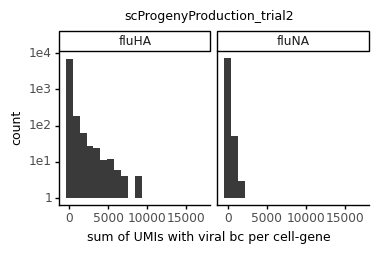

<ggplot: (8794254906534)>

In [11]:
fig = (p9.ggplot((viral_bc_frac
                  .drop_duplicates(subset=['cell_barcode', 'gene'])),
                 p9.aes(x='sum_UMIs_with_viral_bc_for_cell_and_gene')) +
       p9.geom_histogram(bins=20, fill="#3a3a3a") +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='sum of UMIs with viral bc per cell-gene',) +
       p9.scale_y_log10() +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 11 rows containing missing values.


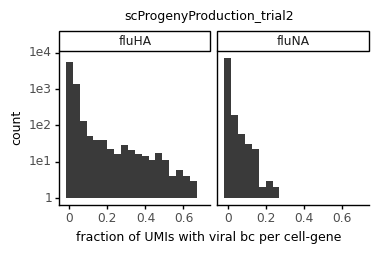

<ggplot: (8794254660087)>

In [12]:
fig = (p9.ggplot((viral_bc_frac
                  .drop_duplicates(subset=['cell_barcode', 'gene'])),
                 p9.aes(x='frac_total_UMIs_with_viral_bc_for_cell_and_gene')) +
       p9.geom_histogram(bins=20, fill="#3a3a3a") +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='fraction of UMIs with viral bc per cell-gene',) +
       p9.scale_y_log10() +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot fraction of barcoded UMIs per cell-gene as a function of total UMI count:

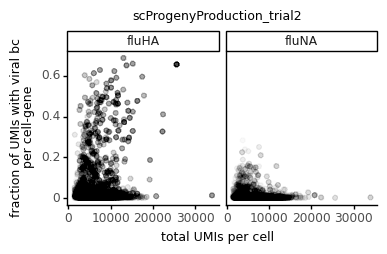

<ggplot: (8794251297747)>

In [13]:
fig = (p9.ggplot(viral_bc_frac,
                 p9.aes(x='total_UMIs',
                        y='frac_total_UMIs_with_viral_bc_for_cell_and_gene')) +
       p9.geom_point(alpha=0.01) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='total UMIs per cell',
               y='fraction of UMIs with viral bc\nper cell-gene') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot fraction of barcoded UMIs per cell-gene as a function of viral UMI count and viral UMI fraction:

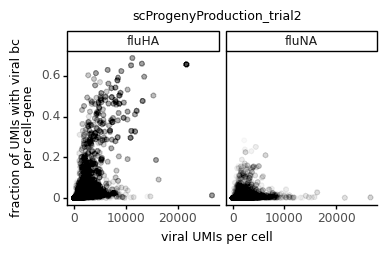

<ggplot: (8794250519854)>

In [14]:
fig = (p9.ggplot(viral_bc_frac,
                 p9.aes(x='viral_UMIs',
                        y='frac_total_UMIs_with_viral_bc_for_cell_and_gene')) +
       p9.geom_point(alpha=0.01) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='viral UMIs per cell',
               y='fraction of UMIs with viral bc\nper cell-gene') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

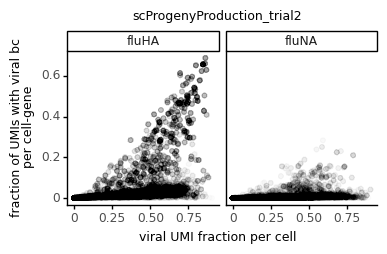

<ggplot: (8794250011558)>

In [15]:
fig = (p9.ggplot(viral_bc_frac,
                 p9.aes(x='frac_viral_UMIs',
                        y='frac_total_UMIs_with_viral_bc_for_cell_and_gene')) +
       p9.geom_point(alpha=0.01) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='viral UMI fraction per cell',
               y='fraction of UMIs with viral bc\nper cell-gene') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot relationship between viral UMI fraction and fraction of viral UMIs with barcode:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


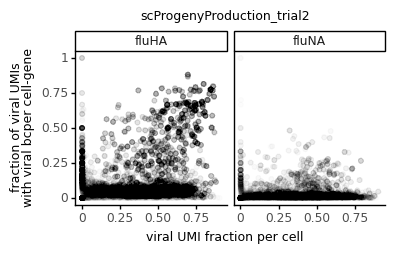

<ggplot: (8794249972423)>

In [16]:
fig = (p9.ggplot(viral_bc_frac,
                 p9.aes(x='frac_viral_UMIs',
                        y='frac_viral_UMIs_with_viral_bc_for_cell_and_gene')) +
       p9.geom_point(alpha=0.01) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='viral UMI fraction per cell',
               y='fraction of viral UMIs\nwith viral bcper cell-gene') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

### Per barcode metrics
Figures that show the outcomes **for each barcode individually.**

Plot distribution of each barcode's fraction of a cell's total UMIs.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 253 rows containing missing values.


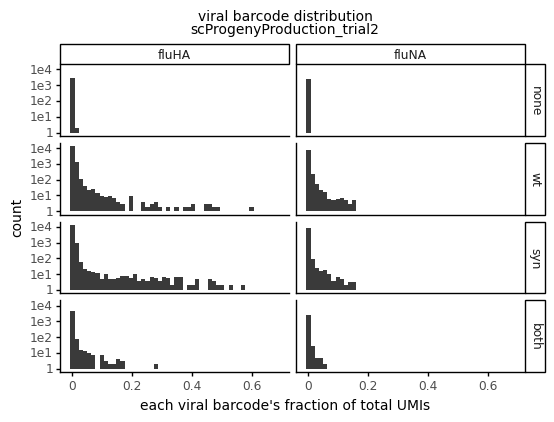

<ggplot: (8794251209686)>

In [17]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=50, fill="#3a3a3a") +
       p9.facet_grid('infecting_viral_tag~gene') +
       p9.ggtitle('viral barcode distribution\n'
                  f'{expt}') +
       p9.labs(x='each viral barcode\'s fraction of total UMIs',) +
       p9.scale_y_log10() +
       p9.theme(figure_size=(6, 4),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot relationship between viral burden (frac_viral_UMIs) and each viral barcode's fraction of total UMIs:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


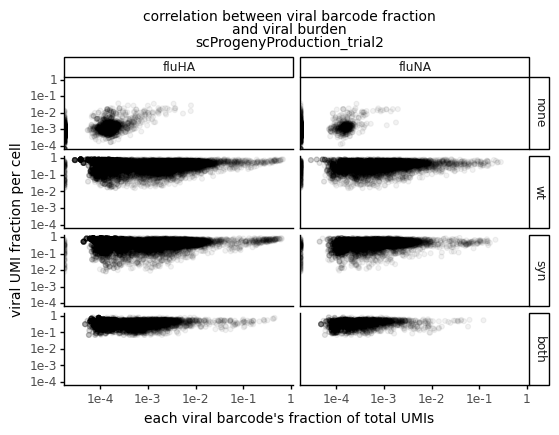

<ggplot: (8794251278710)>

In [18]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='frac_viral_bc_UMIs',
                                       y='frac_viral_UMIs')) +
       p9.geom_point(alpha=0.05) +
       p9.facet_grid('infecting_viral_tag~gene') +
       p9.ggtitle('correlation between viral barcode fraction\n'
                  'and viral burden\n'
                  f'{expt}') +
       p9.labs(x='each viral barcode\'s fraction of total UMIs',
               y='viral UMI fraction per cell') +
       p9.scale_y_log10() +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 4),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

## Statistical Tests
I want to perform a statistical test for each barcode to see if I can reject the null hypothesis that it fits the distribution of barcode UMI counts observed in uninfected cells. All barcodes in uninfected cells should be derived from leaked transcripts.

The general approach is this:
First, extract a mu parameter from distribution of viral barcode fractions in uninfected cells. I will set this arbitrarily at the 95th percentile of the uninfected cell distribution. This will be calculated independently for each barcoded gene.

I will use the mu values to build a null distribution of viral barcode counts for each barcoded gene. I will assume that barcode counts in uninfected cells are poisson distributed. Since poisson calculations assume discrete numbers of outcomes, I will work with counts rather than fractions.

Then, I will test each viral barcode to see if it falls within the null distribution or not. Barcodes that reject the null hypothesis will be retained. Those that do not reject the null hypothesis will be filtered.

### Check for sufficient uninfected cells
I only want to compare to population of uninfected cells if there are sufficient uninfected cells.

For now I will simply hardcode the number at 100.

In [25]:
threshold_uninfected_cells = 100
n_uninfected_cells = (viral_bc_frac
                      .query('infecting_viral_tag == "none"')
                      ['cell_barcode']
                      .nunique())

assert n_uninfected_cells > threshold_uninfected_cells, \
    "Not enough uninfected cells for comparison."

print(f'There are {n_uninfected_cells} uninfected cells. '
      f'This is above the threshold of {threshold_uninfected_cells} cells required.')

There are 2372 uninfected cells. This is above the threshold of 100 cells required.


Calculate cutoff percentile for each gene's distribution in uninfected cells and plot. For now hardcoded to 95th percentile:

The cutoff fraction for a viral barcode on fluHA is 0.00033.
The cutoff fraction for a viral barcode on fluNA is 0.00019.


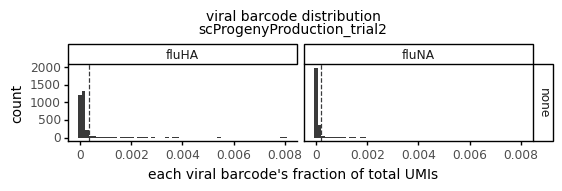

<ggplot: (8794249532823)>

In [106]:
cutoff_percentile = 0.95

uninfected_frac_cutoff = dict()
for gene in barcoded_viral_genes:
    cutoff = (viral_bc_frac
              .query('(infecting_viral_tag == "none") '
                     f'and (gene == "{gene}")')
              ['frac_viral_bc_UMIs']
              .quantile(cutoff_percentile))
    uninfected_frac_cutoff[f'{gene}'] = cutoff
    print(f'The cutoff fraction for a viral barcode on {gene} is {cutoff:.5f}.')

#Convert to DataFrame for plotting
uninfected_frac_cutoff = (pd.DataFrame.from_dict(uninfected_frac_cutoff,
                                                 orient='index',
                                                 columns=['cutoff'])
                          .reset_index()
                          .rename(columns={'index':'gene'}))
uninfected_frac_cutoff
fig = (p9.ggplot((viral_bc_frac
                  .query('infecting_viral_tag == "none"')),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=60, fill="#3a3a3a") +
       p9.geom_vline(uninfected_frac_cutoff,
                     p9.aes(xintercept='cutoff'),
                            linetype='dashed',
                            color='#3A3B3C',
                            size=0.5) +
       p9.facet_grid('infecting_viral_tag~gene') +
       p9.ggtitle('viral barcode distribution\n'
                  f'{expt}') +
       p9.labs(x='each viral barcode\'s fraction of total UMIs',) +
       p9.theme(figure_size=(6, 1),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

In [19]:
#  Temporary cell to create files expected by snakemake.
#  Not final version

print(f"Saving plots to {plot}")
p9.ggsave(plot=fig, filename=plot, verbose=False)

print(f"Saving filtered barcodes to {viral_bc_by_cell_filtered_csv}")

viral_bc_frac.to_csv(viral_bc_by_cell_filtered_csv,
                     columns=['cell_barcode',
                              'gene',
                              'frac_viral_bc_UMIs'],
                     index=False)

Saving plots to results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_filtered.pdf


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


Saving filtered barcodes to results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_filtered.csv.gz
